In [2]:
import numpy as np
import pandas as pd
import re
import sys
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
from nanoporePipelineCommon import *

In [2]:
from tqdm.notebook import tqdm
bam_path = pick_lib_return_path("xrn-1-5tera-smg-6",
                                output_dir_folder="cat_files",
                                file_midfix="cat.sorted.mappedAndPrimary",
                                file_suffix="bam",
                                )
bam_df = SamOrBamFile(bam_path,
                      ).df
print("library loading done!")

Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
06/16/22 @ 01:39:17 PM: Starting to load bam file from: /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/cat_files/cat.sorted.mappedAndPrimary.bam


Processing 3ff6e418-f2e2-471b-86e0-2e9036ed6041:   1%|          | 2731/243527 [00:01<01:35, 2514.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing 86b48883-48fd-496a-85a0-6624082e914c:   5%|▍         | 11115/243527 [00:04<01:25, 2702.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing face668d-f71e-4791-bfbc-507593e42b0d:   8%|▊         | 19585/243527 [00:07<01:16, 2912.31it/s]IOPub message rate exceeded.
The not

06/16/22 @ 01:40:43 PM: Finished loading bam file!
library loading done!


In [12]:
# DO NOT USE THIS TECHNIQUE! The other is worlds faster
def array_for_each_read(cigars_and_genomic_starts, chr_length) -> np.array:  # DO NOT USE THIS
    coverage_array = np.zeros([chr_length], dtype=np.uint32)
    cigar_parsing_iterator = tqdm(cigars_and_genomic_starts, desc=f"Building coverage by making sub arrays")
    for cigar, genomic_start in cigar_parsing_iterator:
        genomic_pos = genomic_start
        parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', cigar)
        parsed_cigar = [(int(length), code) for (length, code) in parsed_cigar]
    
        read_coverage_array = np.zeros([chr_length], dtype=np.uint32)
    
        for length, code in parsed_cigar:
            if code in ['N', 'D']:
                genomic_pos += length
            elif code in ['M']:
                read_coverage_array[genomic_pos:genomic_pos + length] = 1
                genomic_pos += length
        coverage_array += read_coverage_array
    return coverage_array


def _add_to_main_array_for_each_read(cigars_and_genomic_starts, chr_length, count_Ds_as_maps=False) -> np.array:
    coverage_array = np.zeros([chr_length], dtype=np.uint32)
    cigar_parsing_iterator = tqdm(cigars_and_genomic_starts, desc=f"Building coverage by adding to main array")
    
    gaps = ['N']  # introns
    maps = ['M']  # mapped segments
    if count_Ds_as_maps:
        maps.append('D')
    else:
        gaps.append('D')
    for cigar, genomic_start in cigar_parsing_iterator:
        genomic_pos = genomic_start
        parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', cigar)
        parsed_cigar = [(int(length), code) for (length, code) in parsed_cigar]
    
        for length, code in parsed_cigar:
            if code in gaps:
                genomic_pos += length
            elif code in maps:  # TODO: the D "belongs" above, but not yet...
                coverage_array[genomic_pos:genomic_pos + length] += 1
                genomic_pos += length
    return coverage_array


def _run_coverage_calc(bam_df, chrs=("I", "II", "III", "IV", "V", "MtDNA"), count_Ds_as_maps=False):
    if "original_chr_pos" in bam_df.columns:
        gen_pos_col = "original_chr_pos"
    else:
        gen_pos_col = "chr_pos"
    
    # These are actually annotation ends:
    chr_max_length_dict = {'I': 15072426,
                           'II': 15279420,
                           'III': 13783459,
                           'IV': 17493829,
                           'V': 20922738,
                           'MtDNA': 13327}
    # Because of some python weirdness, we need to turn single chromosomes into lists!
    if not isinstance(chrs, (list, tuple)):
        chrs = [chrs]
    
    # First filter the chr dict, so we only use the ones that showed up in the method call:
    chr_max_length_dict = {chromosome: length for chromosome, length
                           in chr_max_length_dict.items()
                           if chromosome in chrs}
    array_dict = {}
    for chromosome, chr_length in chr_max_length_dict.items():
        print(f"Starting to build coverage array for chromosome: {chromosome}")
        chr_df = bam_df.query(f"chr_id == '{chromosome}'")
        cigars_and_genomic_start_positions = list(zip(chr_df.cigar.to_list(), chr_df[gen_pos_col].to_list()))
        coverage_array = _add_to_main_array_for_each_read(cigars_and_genomic_start_positions, chr_length, count_Ds_as_maps=count_Ds_as_maps)
        array_dict[chromosome] = coverage_array
    return array_dict

In [27]:
# coverage_dict_adapted = _run_coverage_calc(bam_df, technique_method=_add_to_main_array_for_each_read)
coverage_dict_adapted = _run_coverage_calc(bam_df.query("t5 == '+'"), technique_method=_add_to_main_array_for_each_read)
coverage_dict_unadapted = _run_coverage_calc(bam_df.query("t5 == '-'"), technique_method=_add_to_main_array_for_each_read)

Starting to build coverage array for chromosome: I


Building coverage by adding to main array:   0%|          | 0/1956 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: II


Building coverage by adding to main array:   0%|          | 0/675 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: III


Building coverage by adding to main array:   0%|          | 0/501 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: IV


Building coverage by adding to main array:   0%|          | 0/610 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: V


Building coverage by adding to main array:   0%|          | 0/601 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: MtDNA


Building coverage by adding to main array:   0%|          | 0/5092 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: I


Building coverage by adding to main array:   0%|          | 0/41947 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: II


Building coverage by adding to main array:   0%|          | 0/42168 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: III


Building coverage by adding to main array:   0%|          | 0/30922 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: IV


Building coverage by adding to main array:   0%|          | 0/34922 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: V


Building coverage by adding to main array:   0%|          | 0/33320 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: MtDNA


Building coverage by adding to main array:   0%|          | 0/18197 [00:00<?, ?it/s]

HOLY CRAP! Adding to the main array rather than building sub-arrays and combining is SOOOOO much faster it's crazy
Can do a quart million reads in ~25 seconds

Generating subfigure for chromosome: I
Generating subfigure for chromosome: II
Generating subfigure for chromosome: III
Generating subfigure for chromosome: IV
Generating subfigure for chromosome: V
Generating subfigure for chromosome: MtDNA


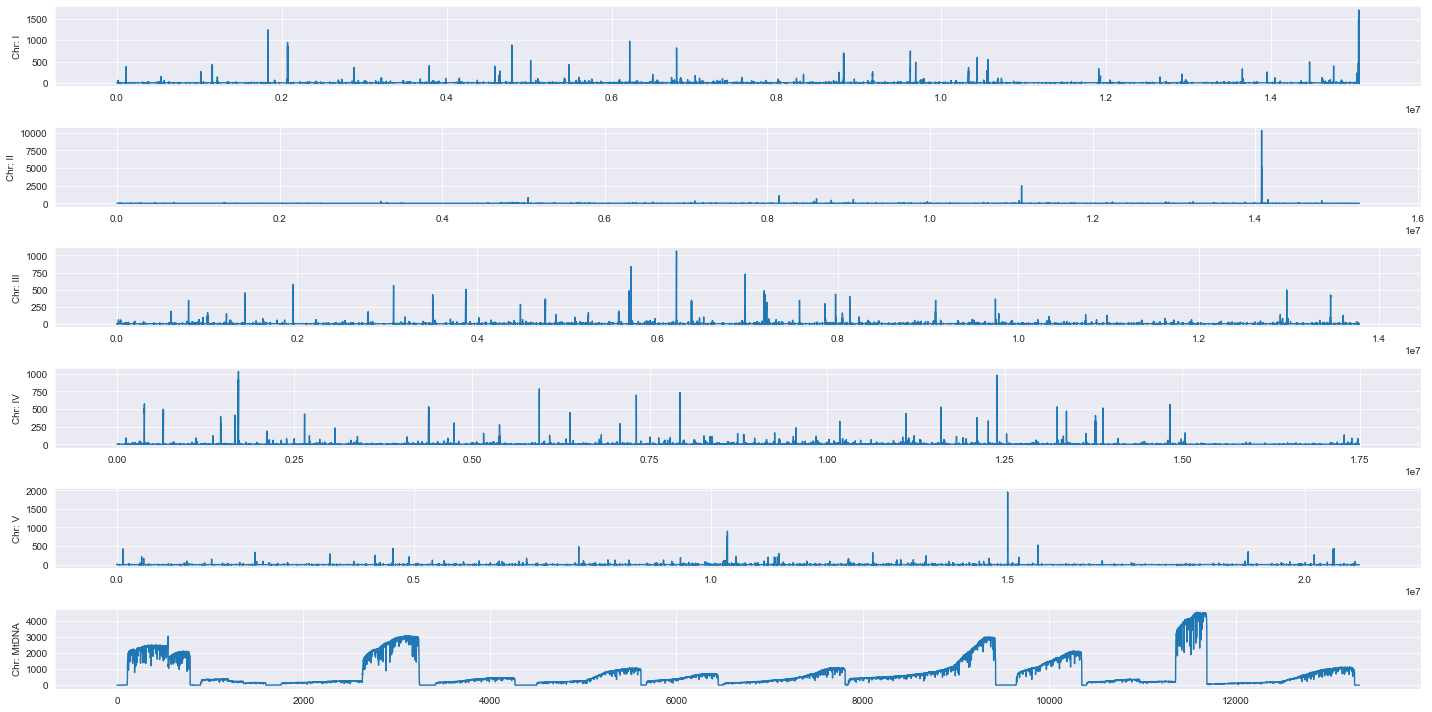

In [7]:
# import matplotlib.pyplot as plt
# 
# fig, ax = plt.subplots(len(coverage_dict), 1,
#                        figsize=(20,10),
#                        # sharex=True,
#                        )
# plt.style.use("seaborn-paper")
# 
# for i, (chromosome, coverage_array) in enumerate(coverage_dict.items()):
#     print(f"Generating subfigure for chromosome: {chromosome}")
#     y1 = coverage_array
#     # x = np.arange(len(coverage_array))
#     # y0 = np.zeros(len(coverage_array))
#     ax[i].plot(y1, drawstyle="steps-pre")
#     ax[i].set_ylabel(f"Chr: {chromosome}")
#     # ax[i].set_yscale("log")
# plt.tight_layout()
# plt.style.use("seaborn-paper")
# # plt.savefig(f"./outputDir/{get_dt(for_file=True)}_wholeGenomeCoverage.png")
# plt.show()

# Do this with a single gene locus

In [3]:
def _get_gene_coordinates(gene_id=None, gene_name=None, parsed_gtf_path="/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.gtf.parquet") -> (str, int, int):
    # First make sure we got something to look up:
    gene_id_bool = isinstance(gene_id, str)
    gene_name_bool = isinstance(gene_name, str)
    if not gene_id_bool and not gene_name_bool:
        raise NotImplementedError(f"Please pass a gene_id or a gene_name!")
    # Load the parsed gtf_file
    try:
        gtf_df = pd.read_parquet(parsed_gtf_path)[["gene_id", "gene_name", "feature", "chr", "start", "end"]].query("feature == 'gene'")
    except FileNotFoundError:
        raise FileNotFoundError(f"Please make sure there is a parsed gtf file at: {parsed_gtf_path}")
    
    # Get the gene of interest!
    try:
        if gene_id_bool:
            entry_of_interest = gtf_df.query(f"gene_id == '{gene_id}'").reset_index(drop=True).iloc[0].to_dict()
            gene_name = entry_of_interest["gene_name"]
        else:  # if gene_name_bool
            entry_of_interest = gtf_df.query(f"gene_name == '{gene_name}'").reset_index(drop=True).iloc[0].to_dict()
            gene_id = entry_of_interest["gene_id"]
    except IndexError:
        raise IndexError(f"Gene of interest (gene_id: {gene_id} / gene_name: {gene_name}) not found!")
    chromosome = entry_of_interest["chr"]
    start = entry_of_interest["start"]
    end = entry_of_interest["end"]
    print(f"Found entry for {gene_name} ({gene_id}) on chromosome {chromosome:>5} at ({start}, {end})")
    return chromosome, start, end

In [28]:
bam_wt_path = pick_lib_return_path("xrn-1-5tera",
                                output_dir_folder="cat_files",
                                file_midfix="cat.sorted.mappedAndPrimary",
                                file_suffix="bam",
                                )
bam_wt_df = SamOrBamFile(bam_wt_path,
                      ).df
print("library loading done!")

Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
06/16/22 @ 02:02:44 PM: Starting to load bam file from: /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/cat_files/cat.sorted.mappedAndPrimary.bam


Processing 8481be0d-527a-4b8f-91cc-014fa59d1557:   0%|          | 2869/721766 [00:01<04:37, 2587.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing b924ce8e-2ebc-4fda-bd7a-ce11b81facc1:   1%|          | 8595/721766 [00:03<04:29, 2645.04it/s]


KeyboardInterrupt: 

Found entry for ubl-1 (WBGene00006725) on chromosome   III at (3068306, 3069210)
Starting to build coverage array for chromosome: III


Building coverage by adding to main array:   0%|          | 0/501 [00:00<?, ?it/s]

Starting to build coverage array for chromosome: III


Building coverage by adding to main array:   0%|          | 0/30922 [00:00<?, ?it/s]

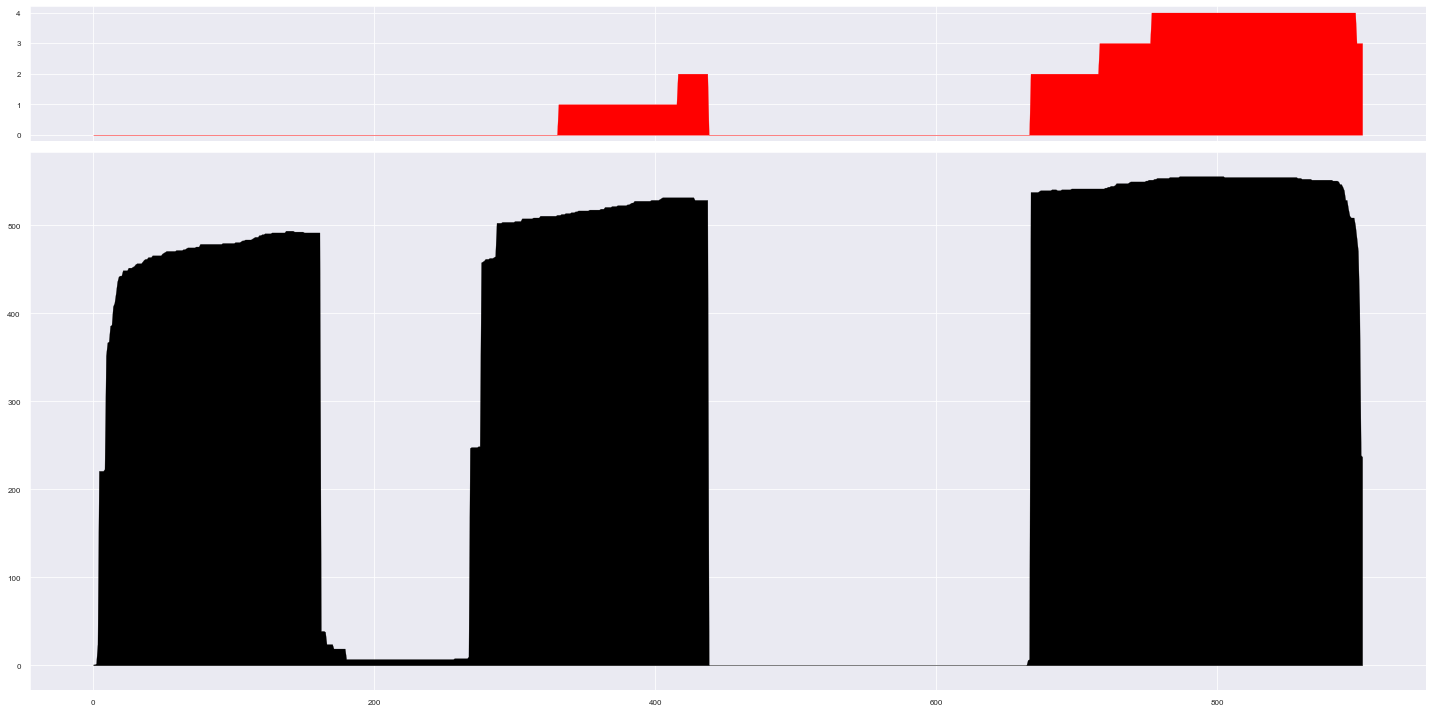

In [59]:
# import matplotlib.pyplot as plt
# target_gene_name = "ubl-1"
# target_gene_chr, target_start, target_end = _get_gene_coordinates(gene_name=target_gene_name)
# target_chr_array_ad = _run_coverage_calc(bam_df.query("t5 == '+'"), chrs=target_gene_chr)[target_gene_chr]
# target_chr_array_unad = _run_coverage_calc(bam_df.query("t5 == '-'"), chrs=target_gene_chr)[target_gene_chr]
# target_locus_array_ad = target_chr_array_ad[target_start: target_end]
# target_locus_array_unad = target_chr_array_unad[target_start: target_end]
# 
# index_array = np.arange(len(target_locus_array_ad))
# zeros_array = np.zeros(len(target_locus_array_ad))
# 
# fig, ax = plt.subplots(2, 1,
#                        figsize=(20,10),
#                        sharex=True,
#                        gridspec_kw={"height_ratios": [1,4]}
#                        )
# 
# ax[1].fill_between(index_array, zeros_array, target_locus_array_unad, color='black')
# ax[0].fill_between(index_array, zeros_array, target_locus_array_ad, color='red')
# 
# plt.tight_layout()
# plt.style.use("seaborn-paper")
# plt.savefig(f"./outputDir/{get_dt(for_file=True)}_{target_gene_name}_coverage.svg")
# plt.show()

In [21]:
import matplotlib.pyplot as plt
def coverage_plotting_5tera(bam_df_for_plot, gene_name, save_as=None, count_Ds_as_maps=False, rpm_normalize=False):
    gene_chr, start, end = _get_gene_coordinates(gene_name=gene_name)
    chr_array_ad = _run_coverage_calc(bam_df_for_plot.query("t5 == '+'"), chrs=gene_chr, count_Ds_as_maps=count_Ds_as_maps)[gene_chr]
    chr_array_unad = _run_coverage_calc(bam_df_for_plot.query("t5 == '-'"), chrs=gene_chr, count_Ds_as_maps=count_Ds_as_maps)[gene_chr]
    locus_array_ad = chr_array_ad[start: end]
    locus_array_unad = chr_array_unad[start: end]
    if rpm_normalize:
        norm_factor = bam_df_for_plot.shape[0]
        # Turn the total number of read hits into the 'million of read hits'
        rpm_norm_factor = norm_factor / 1000000
        locus_array_ad = np.divide(locus_array_ad, rpm_norm_factor)
        locus_array_unad = np.divide(locus_array_unad, rpm_norm_factor)
    
    index_array = np.arange(len(locus_array_ad))
    zeros_array = np.zeros(len(locus_array_ad))
    
    fig, ax = plt.subplots(2, 1,
                           figsize=(8,4),
                           sharex=True,
                           gridspec_kw={"height_ratios": [1,4]}
                           )
    
    ax[1].fill_between(index_array, zeros_array, locus_array_unad, color='black')
    ax[0].fill_between(index_array, zeros_array, locus_array_ad, color='red')
    
    plt.tight_layout()
    plt.style.use("seaborn-paper")
    if isinstance(save_as, str):
        plt.savefig(save_as)
    plt.show()

In [5]:
reads_df_genes_raw, compressed_df_genes_raw = load_and_merge_lib_parquets(["xrn-1-5tera", "xrn-1-5tera-smg-6"], drop_sub_n=1, add_tail_groupings=False, drop_failed_polya=False, group_by_t5=True)
reads_df, compressed_df = reads_df_genes_raw.copy(), compressed_df_genes_raw.copy()
print("Done!")

Loading readAssignments file from: /data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.allChrs.parquet... Done.
Looking for files for libraries: ['xrn-1-5tera', 'xrn-1-5tera-smg-6']
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Loading parquet for xrn-1-5tera lib... Done.
'original_chr_pos' column already found in dataframe, skipping adjustment for 5'ends!
Loading parquet for xrn-1-5tera-smg-6 lib... Done.
'original_chr_pos' column already found in dataframe, skipping adjustment for 5'ends!
Finished assignment merge!. . .
Read counts post gene assignment:  937835
Read counts post unassigned drop:  636409
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_i

Counting reads per gene: 100%|██████████| 31278/31278 [00:00<00:00, 51573.24it/s]


Gene counts pre sub-1 gene_hits drop:  31278
Gene counts post sub-1 gene_hits drop:  31278
Done!


Found entry for tba-1 (WBGene00006528) on chromosome     I at (9785778, 9787624)
Starting to build coverage array for chromosome: I


Building coverage by adding to main array: 100%|██████████| 3549/3549 [00:00<00:00, 5872.29it/s]


Starting to build coverage array for chromosome: I


Building coverage by adding to main array: 100%|██████████| 85801/85801 [00:15<00:00, 5673.60it/s]


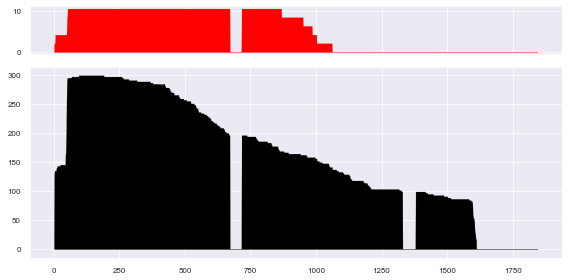

Found entry for tba-1 (WBGene00006528) on chromosome     I at (9785778, 9787624)
Starting to build coverage array for chromosome: I


Building coverage by adding to main array: 100%|██████████| 500/500 [00:00<00:00, 8277.10it/s]


Starting to build coverage array for chromosome: I


Building coverage by adding to main array: 100%|██████████| 23150/23150 [00:03<00:00, 7108.92it/s]


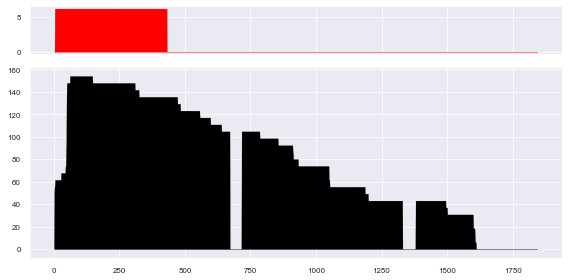

In [22]:
gene_of_interest = "tba-1"

coverage_plotting_5tera(reads_df.query("lib == 'xrn-1-5tera'"), gene_name=gene_of_interest,  count_Ds_as_maps=True, rpm_normalize=True)
coverage_plotting_5tera(reads_df.query("lib == 'xrn-1-5tera-smg-6'"), gene_name=gene_of_interest,  count_Ds_as_maps=True, rpm_normalize=True)

In [20]:
np.divide(np.array([125415, 1515, 15, 15225], dtype=np.uint32), 500)

array([2.5083e+02, 3.0300e+00, 3.0000e-02, 3.0450e+01])